# Fraud case study



## Day 1: building a fraud model

## Day 2: building an app/dashboard

## Tips success

You will quickly run out of time:

*  Use CRISP-DM workflow to analyze data and build a model
*  Iterate quickly, test often, commit often
*  Build deadlines for your work so you stay on track
*  Should have a model by end of day 1
*  Start app once model is working

### CRISP-DM workflow

Follow the [CRISP-DM](https://en.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining) steps:

1.  Business understanding
2.  Data understanding
3.  Data preparation
4.  Modeling
5.  Evaluation
6.  Deployment

# Introduction to case study: data & problem

Let's look at the data.  What format is the data in?  How do you extract it?

In [1]:
ls -lh data

total 573360
-rw-r--r--@ 1 alexanderwyman  staff   239M Aug  2  2016 data.json
-rw-r--r--  1 alexanderwyman  staff    33M Sep 10 18:11 data.zip
-rw-r--r--@ 1 alexanderwyman  staff   2.1M Sep 10 19:13 subset.json
-rw-r--r--@ 1 alexanderwyman  staff   105K Sep 10 18:11 test_script_examples.csv


Unzip the data so you can load it into Python

In [2]:
!unzip data/data.zip -d data

Archive:  data/data.zip
replace data/data.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Initially, work with a subset at first in order to iterate quickly.  But, the file is one giant line of json:

In [3]:
!wc data/data.json

       0 8173151 250481668 data/data.json


Write a quick and dirty script to pull out the first 100 records so we can get code working quickly.

In [4]:
%%writefile subset_json.py
"""head_json.py - extract a couple records from a huge json file.

Syntax: python head_json.py < infile.json > outfile.json
"""

import sys

start_char = '{'
stop_char = '}'
n_records = 100
level_nesting = 0

while n_records != 0:
    ch = sys.stdin.read(1)
    sys.stdout.write(ch)
    if ch == start_char:
        level_nesting += 1
    if ch == stop_char:
        level_nesting -= 1
        if level_nesting == 0:
            n_records -= 1
sys.stdout.write(']')


Overwriting subset_json.py


In [5]:
!python subset_json.py < data/data.json > data/subset.json

In [19]:
import pandas as pd

df = pd.read_json('data/data.json')

In [20]:
df.head().T

,0,1,2,3,4
acct_type,fraudster_event,premium,premium,premium,premium
approx_payout_date,1266062400,1296720000,1296172800,1388966400,1297900800
body_length,3852,3499,2601,12347,2417
channels,5,0,8,6,11
country,US,US,US,IE,US
currency,USD,USD,USD,EUR,USD
delivery_method,0,1,1,1,0
description,"<p><a href=""http://s432.photobucket.com/albums...","<p>Join us for a quick, one-night, community-b...","<h3><span class=""subcategory""><strong>Teacher ...","<p style=""margin-bottom: 1.3em; padding-bottom...",<p>Writers and filmmakers need to understand t...
email_domain,gmail.com,ruf.org,pvsd.k12.ca.us,irishtabletennis.com,artsandbusinesscouncil.org
event_created,1262739706,1293832670,1291090956,1360681570,1291994666


Some of the data is text (and HTML), which will require feature engineering:

* TF-IDF
* Feature hashing
* n-grams

etc.

You will also need to construct a target from `acct_type`.  Fraud events start with `fraud`.  How you define fraud depends on how you define the business problem.

In [21]:
df.acct_type.value_counts(dropna=False)

premium             12373
fraudster_event       851
fraudster             437
spammer_limited       218
spammer_warn          144
tos_warn               91
spammer_noinvite       84
tos_lock               77
locked                 54
fraudster_att           5
spammer_web             2
spammer                 1
Name: acct_type, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   acct_type           14337 non-null  object 
 1   approx_payout_date  14337 non-null  int64  
 2   body_length         14337 non-null  int64  
 3   channels            14337 non-null  int64  
 4   country             14256 non-null  object 
 5   currency            14337 non-null  object 
 6   delivery_method     14321 non-null  float64
 7   description         14337 non-null  object 
 8   email_domain        14337 non-null  object 
 9   event_created       14337 non-null  int64  
 10  event_end           14337 non-null  int64  
 11  event_published     14238 non-null  float64
 12  event_start         14337 non-null  int64  
 13  fb_published        14337 non-null  int64  
 14  gts                 14337 non-null  float64
 15  has_analytics       14337 non-null  int64  
 16  has_

Is missing data a problem?  What are your options for handling missing data?

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
approx_payout_date,14337.0,1.350933e+09,2.401300e+07,1.171256e+09,1.334221e+09,1.355805e+09,1.370646e+09,1.523488e+09
body_length,14337.0,3.672522e+03,5.758113e+03,0.000000e+00,7.500000e+02,1.990000e+03,4.280000e+03,6.553500e+04
channels,14337.0,6.176676e+00,3.860333e+00,0.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.300000e+01
delivery_method,14321.0,4.395643e-01,5.914866e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
event_created,14337.0,1.345825e+09,2.404107e+07,1.170332e+09,1.329754e+09,1.351043e+09,1.365346e+09,1.382012e+09
event_end,14337.0,1.350501e+09,2.401299e+07,1.170824e+09,1.333789e+09,1.355373e+09,1.370214e+09,1.523056e+09
event_published,14238.0,1.340854e+09,8.750386e+07,0.000000e+00,1.329499e+09,1.351099e+09,1.365478e+09,1.381608e+09
event_start,14337.0,1.350205e+09,2.398787e+07,1.170819e+09,1.333406e+09,1.355000e+09,1.370048e+09,1.418850e+09
fb_published,14337.0,1.274325e-01,3.334685e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
gts,14337.0,2.430231e+03,9.142308e+03,0.000000e+00,1.164100e+02,4.319300e+02,1.547260e+03,3.062939e+05


In [32]:
import numpy as np
df['fraud'] = np.where((df['acct_type'] == 'fraudster') | (df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster_att'), 1, 0)

In [25]:
df['org_fb_twitter'] = df['org_facebook'] + df['org_twitter']

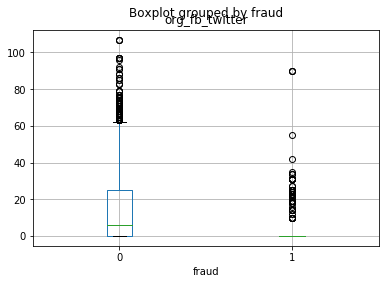

In [13]:
df.boxplot('org_fb_twitter', 'fraud')

In [14]:
boxes = ['delivery_method', 'has_logo', 'name_length', 'org_facebook', 'org_twitter', 'user_age']

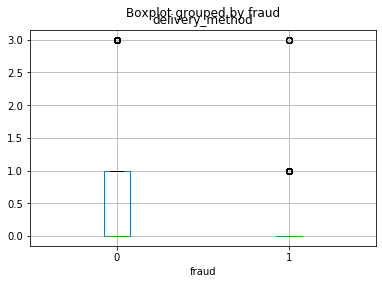

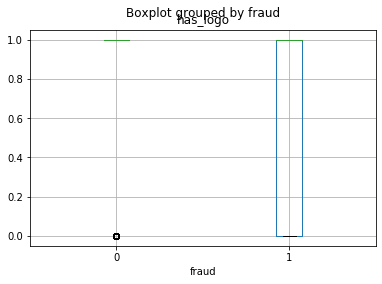

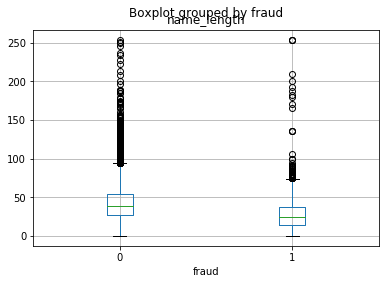

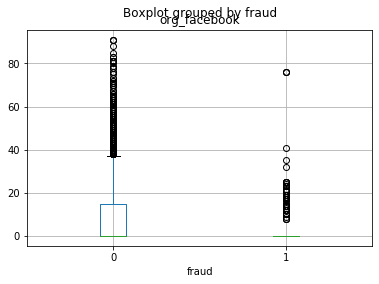

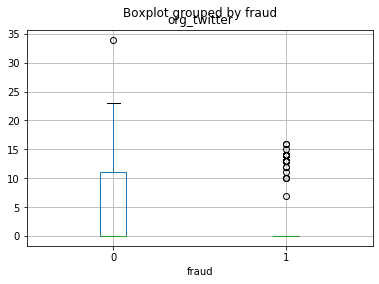

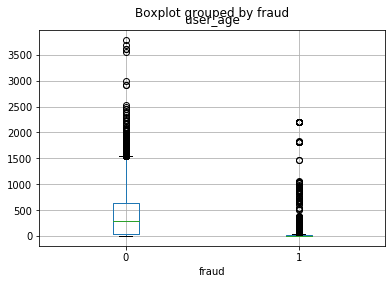

In [15]:
for box in boxes:
    df.boxplot(box, 'fraud')

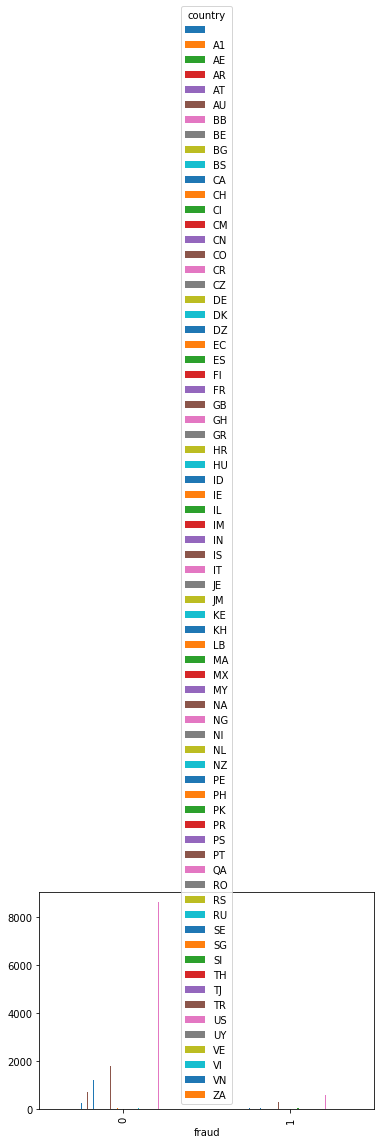

In [16]:
df.groupby(['country','fraud'])['fraud'].count().unstack(0).plot.bar()

In [17]:
df.ticket_types[0]
#ticket_types = list?

[{'event_id': 527017,
  'cost': 25.0,
  'availability': 1,
  'quantity_total': 800,
  'quantity_sold': 0},
 {'event_id': 527017,
  'cost': 50.0,
  'availability': 1,
  'quantity_total': 100,
  'quantity_sold': 0},
 {'event_id': 527017,
  'cost': 550.0,
  'availability': 1,
  'quantity_total': 20,
  'quantity_sold': 0}]

In [42]:
from fuzzywuzzy import fuzz

def split_email(email, get_ending=False):
        email = str(email)
        head, _, tail = email.partition('.')
        if get_ending:
            return tail
        else:
            return head

def feature_eng(df):
        # Insert our target of fraud = 1 and not fraud = 0
        #df['fraud'] = np.where((df['acct_type'] == 'fraudster') | (df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster_att'), 1, 0)

        #break down the email domain into two categories subdomain and tld
        df['subdomain'] = df.apply(lambda row: split_email(row.email_domain), axis=1)
        df['tld'] = df.apply(lambda row: split_email(row.email_domain, get_ending=True), axis=1)

        # Use fuzzywuzzy to find the similarity of the email's subdomain and the organization's name
        df['org_subdomain_similarity'] = df.apply(lambda row: fuzz.token_set_ratio(str(row.subdomain), str(row.org_name)), axis=1)

        #Count the total number of previous payouts to the user
        df['num_previous'] = df.apply(lambda row: len(row.previous_payouts), axis=1)

        #convert columns from seconds to DateTime
        df['date_pub'] = pd.to_datetime(df.event_published, unit='s')
        df['date_start'] = pd.to_datetime(df.event_start, unit='s')

        #Find the number of days until the event from both when it was published and when it was created
        df['public_notification_period'] = (((df.event_start - df.event_published) / 60) / 60) / 24
        df['private_notification_period'] = (((df.event_start - df.event_created) / 60) / 60) / 24

        #Return the feature engineered DataFrame
        return df

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

drop_list = ['acct_type', 'approx_payout_date', 'event_end', 'event_start', 'gts', 'num_payouts', 'payout_type', 'sale_duration', 'sale_duration2', 'ticket_types']
df_for_models = df.drop(drop_list, axis=1)
df_for_models.fillna(0, inplace=True)

In [50]:
y = np.where((df['acct_type'] == 'fraudster') | (df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster_att'), 1, 0)
X = feature_eng(pd.read_json('data/data.zip')).fillna(0)
X = X.drop(drop_list, axis=1)
X = X._get_numeric_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [51]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.predict_proba(X_test)

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.02, 0.98],
       ...,
       [1.  , 0.  ],
       [0.95, 0.05],
       [1.  , 0.  ]])

In [52]:
from sklearn.metrics import f1_score
f1_score(y_test, rf.predict(X_test))

0.927710843373494

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf.predict(X_test))

array([[4287,   19],
       [  41,  385]])

In [ ]:
df.info()

In [ ]:
rand_list = np.random.randint(0, len(df), 10)
rand_list

In [ ]:
test_examples_df = df.loc[rand_list]

In [ ]:
test_examples_df.to_csv('data/test_script_examples.csv')